# The effects of COVID-19 on crime rates in Vancouver

group project proposal:

Neil Li, Tracy Wang, Wendi Zhong

## Introduction

Before the pandemic, our teammate Neil has experienced no crimes more major than perhaps public drunkeness, but once the pandemic started, he has been subjected to two different attempts of grand theft auto and one shooting. This can't help but make us wonder: is this simply a streak of bad luck or is there a genuine correlation between these crimes and the pandemic?

Now this is not a completely unfounded idea, as although research has shown 

### Research Question:

<b>Has Covid 19 affected the frequency and severity of Crimes?<b>

In [1]:
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Dataset Info:

The dataset is downloaded from \"[Vancouver Crime Data](https://geodash.vpd.ca/opendata/)\", an open data dataset provided by the Vancouver Police Department. Which we selected to list all the the crimes commited in every neighbourhood in Vancouver since 2003.

In [2]:
crime_data <- read.csv("crimedata_csv_AllNeighbourhoods_AllYears.csv")
head(crime_data)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


Because we want to have the crime data be more representative of the difference between the years leading up to the pandemic to the years during and after the pandemic, we will filter the data to only include years from 2017 onwards, and before November since 2022 has not had a November yet. We will also only need the columns containing the type of the crime, year the crime was committed.

In [3]:
 crime_data_processed <- crime_data %>%
    filter(YEAR >= 2017, MONTH <= 10) %>%
    select(TYPE, YEAR)

head(crime_data_processed)

,TYPE,YEAR
,<chr>,<int>
1,Break and Enter Commercial,2019
2,Break and Enter Commercial,2019
3,Break and Enter Commercial,2021
4,Break and Enter Commercial,2020
5,Break and Enter Commercial,2022
6,Break and Enter Commercial,2022


We first decided to visualize the overall spread of crime over the six years by taking a sample of size 3000, and bootstrapping 1000 samples from it to see the overall

In [4]:
# create bootstrap samples of the difference in proportion of crimes commited before the pandemic 
# (YEAR < 2020), and obtain a 95% confidence interval from this

crime_data_processed %>%
group_by(YEAR) %>%
summarize(n = n())


YEAR,n
<int>,<int>
2017,35533
2018,36855
2019,40206
2020,32051
2021,26891
2022,28600


Because this is a large dataset, we have the luxury of creating many large samples, and with those large samples we could apply the central limit theorem to get more crucial data.

In [5]:
# calculate mean and standard deviation on the difference between the total amount of 
# crime before and after the pandemic using the central limit theorem and obtain a 95% 
# confidence interval from this

In [6]:
# take 1000 single sample with size 2000 from population

set.seed(2190)

crime_1000_samples <- crime_data_processed %>%
    rep_sample_n(size = 2000, reps = 1000, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))

head(crime_1000_samples)

replicate,TYPE,YEAR,Pandemic
<int>,<chr>,<int>,<chr>
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Other Theft,2022,After
1,Mischief,2021,After
1,Theft of Bicycle,2017,Before


In [7]:
# calculate difference of crimes before and after 2020

samples_diff_dist <- 
crime_1000_samples %>%
    group_by(replicate , Pandemic)%>%
    summarize(n = n()) %>%
    pivot_wider(names_from = Pandemic, values_from = n) %>%
    mutate(diff = Before - After) 

head(samples_diff_dist)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,After,Before,diff
<int>,<int>,<int>,<int>
1,863,1137,274
2,858,1142,284
3,878,1122,244
4,878,1122,244
5,884,1116,232
6,871,1129,258


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



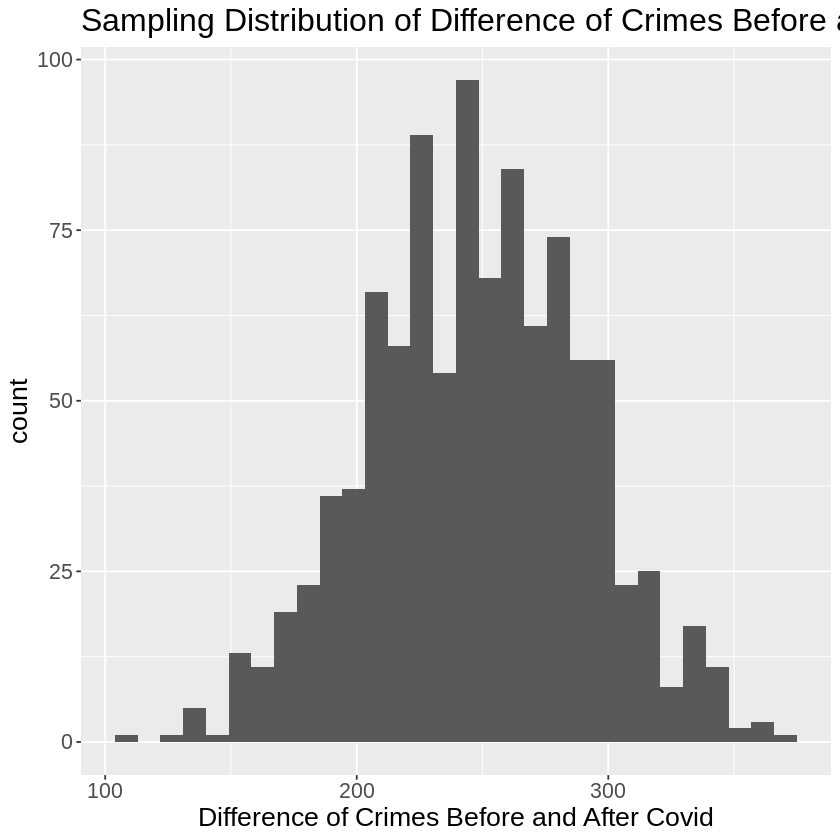

In [8]:
# Visualize size 2000 sampling distribution

sampling_dist_plot <- 
samples_diff_dist %>%
   ggplot(aes(x = diff)) +
   geom_histogram() +
   ggtitle("Sampling Distribution of Difference of Crimes Before and After Covid (n = 2000)") +
   xlab("Difference of Crimes Before and After Covid") +
   theme(text = element_text(size = 16))

sampling_dist_plot

In [13]:
# Get 95% confidence interval
percen_ci <- samples_diff_dist %>%
            get_confidence_interval(type = "percentile", level = 0.95)

percen_ci

lower_ci,upper_ci
<dbl>,<dbl>
161.95,334


mention our plans for hypothesis testing, and future plans to test how different kinds of crimes have been affected.

# References:

Ferguson, E. (2015). Crime and punishment vocabulary with pronunciation. IELTS Liz. Retrieved October 31, 2022, from https://ieltsliz.com/crime-and-punishment-vocabulary/ 

n.a. (n.d.). Crime Data Download. VPD open data. Retrieved October 31, 2022, from https://geodash.vpd.ca/opendata/ 

Nivette, A.E., Zahnow, R., Aguilar, R. et al. A global analysis of the impact of COVID-19 stay-at-home restrictions on crime. Nat Hum Behav 5, 868–877 (2021). https://doi.org/10.1038/s41562-021-01139-z